In [13]:
import cv2
from cardshark.utils import count_points
from cardshark import Vision
from time import time
import pandas as pd

In [14]:
file = pd.read_csv('db.csv', sep=';')

paths = [row[1]['file_path'] for row in file.iterrows()]
pointss = [row[1]['labels'] for row in file.iterrows()]

expected_pointss = [list(map(int, points.split(','))) for points in pointss]

In [15]:
for scale in [1.0, 0.5, 0.25]:
    print(f'For scale {scale}:')
    _all = 0
    _all_positions = 0
    _correct = 0
    _correct_positions = 0
    
    start = time()
    for path, expected_points in zip(paths, expected_pointss):
        vision = Vision(path, scale=scale)
        positions_and_points = [(cv2.boundingRect(contour)[:2], count_points(contents)) for contour, contents in zip(vision.pile_contours, vision.piles_contents)]
        
        positions_and_points.sort(key=lambda pos_and_point: pos_and_point[0][1])
        croupier_points = [positions_and_points[0][1]]
        
        positions_and_points = positions_and_points[1:]
        positions_and_points.sort(key=lambda pos_and_point: pos_and_point[0][0])
        
        players_points = [pos_and_point[1] for pos_and_point in positions_and_points]
        
        points = croupier_points + players_points
        
        _all += 1
        _all_positions += len(points)
        if points == expected_points:
            _correct += 1
        _correct_positions += [p == ep for p, ep in zip(points, expected_points)].count(True)
        
    total_time = time() - start
    
    
    print(f"Accuracy (exact):      {_correct/_all * 100:.3f} %    Time: {total_time:.3f} s  Frames: {len(paths)}")
    print(f"Accuracy (positional): {_correct_positions/_all_positions * 100:.3f} %    Average Time per Frame: {total_time / len(paths):.3f} s")
    print()
    print()

For scale 1.0:
Accuracy (exact):      96.923 %    Time: 20.570 s  Frames: 65
Accuracy (positional): 99.026 %    Average Time per Frame: 0.316 s


For scale 0.5:
Accuracy (exact):      89.231 %    Time: 14.656 s  Frames: 65
Accuracy (positional): 97.403 %    Average Time per Frame: 0.225 s


For scale 0.25:
Accuracy (exact):      47.692 %    Time: 12.817 s  Frames: 65
Accuracy (positional): 75.325 %    Average Time per Frame: 0.197 s


In [26]:
import seaborn as sns
import numpy as np

In [41]:
acc = np.array([96.923, 89.231, 47.692, 99.026, 97.403, 75.325])
time_per_frame = [0.316, 0.225, 0.197, 0.316, 0.225, 0.197]
scale = [1.0, 0.5, 0.25, 1.0, 0.5, 0.25]
acc_kind = ['exact', 'exact', 'exact', 'positional', 'positional', 'positional']

x = list(zip(acc, time_per_frame, scale, acc_kind))

In [43]:
data = pd.DataFrame.from_records(x, columns=['Accuracy', 'Time per Frame', 'Scale', 'Accuracy Kind'])

data

,Accuracy,Time per Frame,Scale,Accuracy Kind
0,96.923,0.316,1.00,exact
1,89.231,0.225,0.50,exact
2,47.692,0.197,0.25,exact
3,99.026,0.316,1.00,positional
4,97.403,0.225,0.50,positional
5,75.325,0.197,0.25,positional


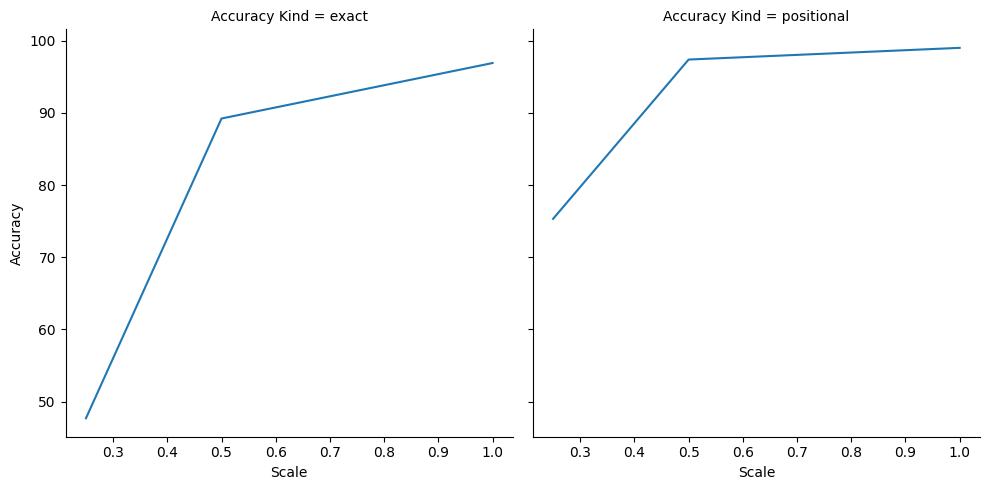

In [46]:
sns.relplot(data=data, x='Scale', y='Accuracy', col='Accuracy Kind', kind="line")